# Trabajo Práctico 2: Análisis con Boosting - Organización de Datos

**Alumnos y Padrón**
+ Craviotto Roitbarg, Mateo Exequiel - 106255 
+ Gómez, Joaquín - 103735

https://github.com/joaqogomez/Organizacion-de-datos-fiuba

## Configuraciones Iniciales
Primero, importamos las bibliotecas que vamos a utilizar:

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

In [3]:
from preprocessing import dividir_dataset
from preprocessing import preparar_dataset
from preprocessing import aplicar_one_hot_encoding

In [4]:
from funciones_auxiliares import graficar_auc_roc
from funciones_auxiliares import traer_df

## Carga del set de datos
Cargamos el dataset y aplicamos las funciones necesarias para adecuarlo al modelo:

In [5]:
df = traer_df()
df = preparar_dataset(df)
df = aplicar_one_hot_encoding(df)

También segmentamos el dataset en X e y (target), y luego lo dividimos en subsets de entrenamiento y validation development (test)

In [6]:
X, y = dividir_dataset(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

## Búsqueda de hiperparámetros
Definimos los mejores hiperparámetros mediante la siguiente función de búsqueda. Estos son la función de pérdida, la cantidad de estimadores a utilizar, el learning rate o tasa de aprendizaje, y el criterio. Nos quedamos con la combinación que maximice la métrica de comparación utilizada, que es AUC-ROC.

Nota: No se utilizó el criterio 'mae' porque observamos el siguiente mensaje en la documentación, que dice que ese criterio está obsoleto.

"Deprecated since version 0.24: criterion='mae' is deprecated and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting."

In [7]:
def definir_mejores_hiperparametros(X, y):    
    metrics = []
    y_array=np.array(y)
    for funcion_perdida in ['deviance', 'exponential']:
        for estimadores in [1, 10, 20, 50, 100, 150, 200]:
            for learning_rate in [0.001, 0.01, 0.1]:
                for criterio in ['friedman_mse', 'mse']:
                    kf = StratifiedKFold(n_splits=5)
                    metricas_de_la_combinacion = []
                    for fold_index, (train_index, test_index) in enumerate(kf.split(X, y_array)):
                        boosting = GradientBoostingClassifier(loss = funcion_perdida, n_estimators = estimadores, learning_rate = learning_rate, criterion = criterio)
                        boosting.fit(X.iloc[train_index], y.iloc[train_index])
                        y_pred = boosting.predict_proba(X.iloc[test_index])[:, 1]
                        metricas_de_la_combinacion.append(roc_auc_score(y.iloc[test_index], y_pred))
                        
                    metrics.append((funcion_perdida, estimadores, learning_rate, criterio, np.mean(metricas_de_la_combinacion)))
                
    df_metrics = pd.DataFrame(metrics, columns=['funcion_perdida','estimadores','learning_rate', 'criterio', 'rocauc'])
    mejor_combinacion = df_metrics[df_metrics["rocauc"] ==  max(df_metrics.rocauc)]   
    return mejor_combinacion

## Entrenamiento y predicción con el dataset original
Buscamos la mejor combinación de hiperparámetros para este dataset, con la función anteriormente mencionada.

In [8]:
mejor_combinacion = definir_mejores_hiperparametros(X, y)

Observamos que la mejor combinación de hiperparámetros es la siguiente:

In [9]:
parametros_boosting = mejor_combinacion.loc[:].values[0]
mejor_loss = parametros_boosting[0]
mejor_n_estimators = parametros_boosting[1]
mejor_learning_rate = parametros_boosting[2]
mejor_criterio = parametros_boosting[3]
print(f'Mejor función de pérdida: {mejor_loss}')
print(f'Mejor número de estimadores: {mejor_n_estimators}')
print(f'Mejor learning rate (tasa de aprendizaje): {mejor_learning_rate}')
print(f'Mejor criterio: {mejor_criterio}')

Mejor función de pérdida: exponential
Mejor número de estimadores: 200
Mejor learning rate (tasa de aprendizaje): 0.1
Mejor criterio: mse


Entrenamos el ensamble de modelos con esa combinación:

In [10]:
boosting = GradientBoostingClassifier(loss = mejor_loss, n_estimators = mejor_n_estimators, learning_rate = mejor_learning_rate, criterion = mejor_criterio)
boosting.fit(X_train,y_train)

GradientBoostingClassifier(criterion='mse', loss='exponential',
                           n_estimators=200)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

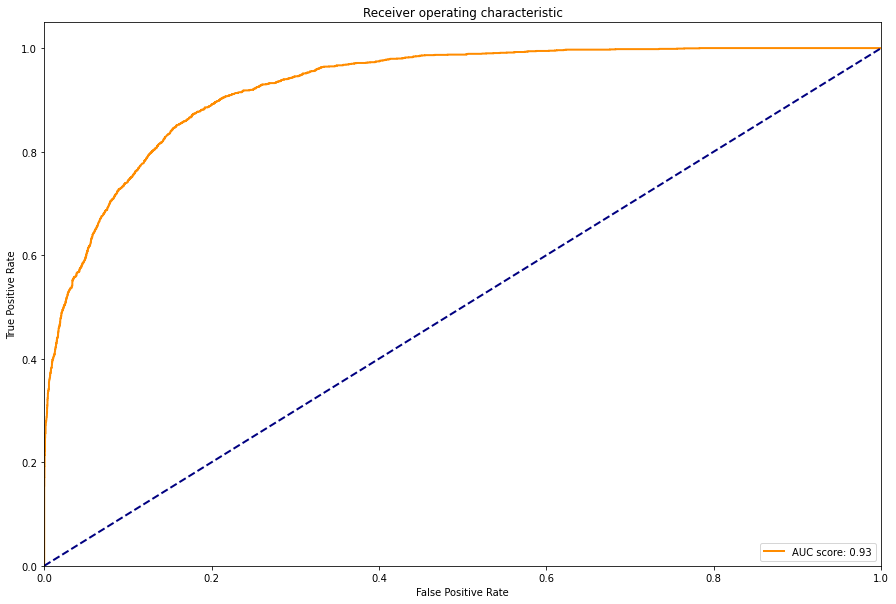

El valor de la metrica AUC-ROC para este modelo es: 0.9267016150714442


In [11]:
y_pred = boosting.predict(X_test)
y_pred_proba = boosting.predict_proba(X_test)[:, 1]
graficar_auc_roc(y_test, y_pred_proba)

Podemos observar que el AUC score dio considerablemente alto, aproximadamente 0.93. Teniendo en cuenta que 1 es un clasificador ideal, podemos decir que Boosting está bastante cerca de serlo, dentro de los modelos que probamos.

Luego, imprimimos el classification report:

In [12]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.892     0.940     0.915      6159
   Tiene Alto Valor Adquisitivo      0.777     0.645     0.705      1982

                       accuracy                          0.868      8141
                      macro avg      0.834     0.793     0.810      8141
                   weighted avg      0.864     0.868     0.864      8141



Se puede ver un f1-score (que tiene en cuenta precision y recall) muy alto para las instancias que no tienen alto valor adquisitivo. Por otra parte, en el caso de los que si tienen alto valor adquisitivo, a pesar de que no sea igual de alto, el f1-score es considerablemente bueno, teniendo en cuenta el resultado en el resto de los modelos. 

Por último, mostramos la matriz de confusión correspondiente, donde se puede confirmar visualmente lo informado por el classification report:

In [13]:
from funciones_auxiliares import graficar_matriz_confusion

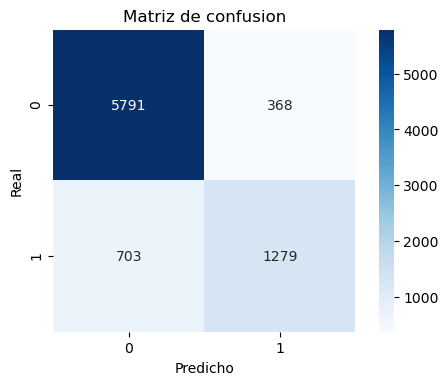

In [14]:
graficar_matriz_confusion(y_test, y_pred)

## Entrenamiento y predicción con el dataset ampliado
Como otra técnica de preprocesamiento, decidimos expandir el dataset utilizando clustering para obtener cuatro nuevas columnas. Las columnas corresponden a la utilización de K-means con 2, 4, 6 y 10 como cantidad de clusters usados. 

In [15]:
from preprocessing import expandir_dataset

Expandimos el dataset y realizamos el split del mismo en los subsets de entrenamiento y validación.

In [16]:
X_exp = expandir_dataset(X)
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y, test_size=0.25, random_state=0)

Buscamos la mejor combinación de hiperparámetros para este dataset.

In [17]:
mejor_combinacion = definir_mejores_hiperparametros(X_exp, y)

A continuación, vemos la mejor combinación de hiperparámetros obtenida.

In [18]:
parametros_boosting = mejor_combinacion.loc[:].values[0]
mejor_loss = parametros_boosting[0]
mejor_n_estimators = parametros_boosting[1]
mejor_learning_rate = parametros_boosting[2]
mejor_criterio = parametros_boosting[3]
print(f'Mejor función de pérdida: {mejor_loss}')
print(f'Mejor número de estimadores: {mejor_n_estimators}')
print(f'Mejor learning rate (tasa de aprendizaje): {mejor_learning_rate}')
print(f'Mejor criterio: {mejor_criterio}')

Mejor función de pérdida: exponential
Mejor número de estimadores: 200
Mejor learning rate (tasa de aprendizaje): 0.1
Mejor criterio: mse


Entrenamos Boosting con la mejor combinación.

In [19]:
boosting_expandido = GradientBoostingClassifier(loss = mejor_loss, n_estimators = mejor_n_estimators, learning_rate = mejor_learning_rate, criterion = mejor_criterio)
boosting_expandido.fit(X_exp_train, y_exp_train)

GradientBoostingClassifier(criterion='mse', loss='exponential',
                           n_estimators=200)

Y ahora hacemos que prediga sobre el dataset expandido. Graficamos también la curva ROC con su respectivo resultado en la métrica AUC-ROC.

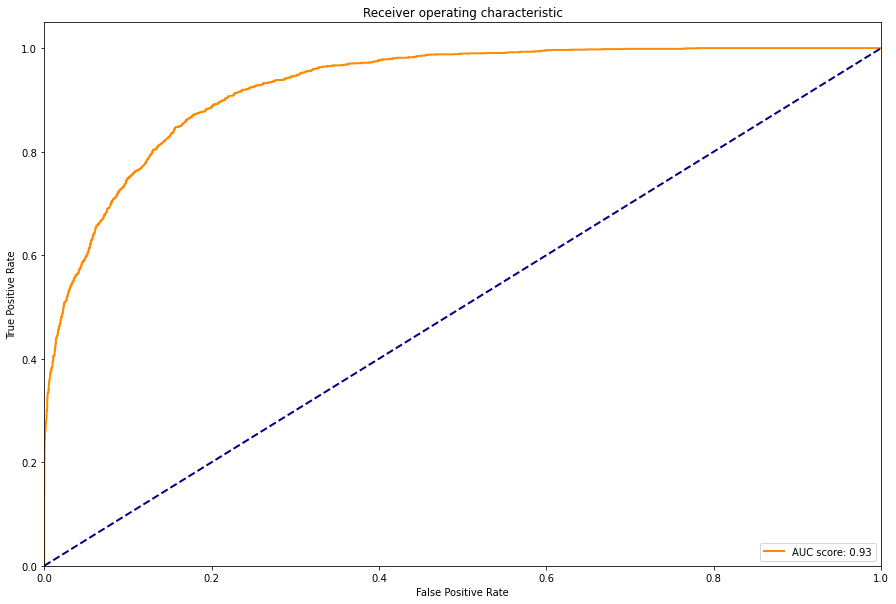

El valor de la metrica AUC-ROC para este modelo es: 0.9266356700481309


In [20]:
y_pred = boosting_expandido.predict(X_exp_test)
y_pred_proba = boosting_expandido.predict_proba(X_exp_test)[:, 1]
graficar_auc_roc(y_exp_test, y_pred_proba)

Podemos observar que Boosting con el dataset ampliado dio un resultado en AUC score muy similar al anterior, pero ligeramente superior.

A continuación, se muestra el classification report, que muestra otras métricas como precision, recall, accuracy, etc.

In [21]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.891     0.940     0.915      6159
   Tiene Alto Valor Adquisitivo      0.775     0.643     0.703      1982

                       accuracy                          0.868      8141
                      macro avg      0.833     0.791     0.809      8141
                   weighted avg      0.863     0.868     0.863      8141



Por último, mostramos la matriz de confusión correspondiente a la predicción con Boosting sobre el dataset ampliado:

In [22]:
from funciones_auxiliares import graficar_matriz_confusion

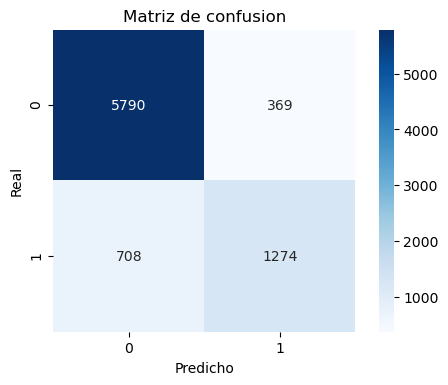

In [23]:
graficar_matriz_confusion(y_exp_test, y_pred)

Podemos ver que con el dataset expandido se obtuvo un resultado muy similar al del dataset original.

## Predicción con el dataset de test holdout
A continuación, realizamos la predicción con Boosting con el dataset ampliado sobre el dataset de holdout, ya que es el que mejor se desempeñó según la métrica AUC-ROC, y la escribimos al archivo 'Boosting.csv'

In [24]:
from funciones_auxiliares import traer_holdout
from preprocessing import preparar_holdout
from funciones_auxiliares import escribir_predicciones

In [25]:
holdout = traer_holdout()
ids, holdout = preparar_holdout(holdout)
holdout = expandir_dataset(holdout)
holdout = aplicar_one_hot_encoding(holdout)

In [26]:
predicciones = boosting_expandido.predict(holdout)
escribir_predicciones(ids, predicciones, "Boosting")